## Time Series Forecasting with Stacked LSTM Models

In this project, we applied Stacked Long Short-Term Memory (LSTM) neural networks to perform time series forecasting on the Air Passengers dataset. The goal of this work was to build a predictive model that can forecast the number of air passengers based on historical data.



In [30]:
import pandas as pd 
import numpy as np         
import matplotlib.pyplot as plt  

from datetime import datetime 

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense, Dropout
from numpy import array
from sklearn.metrics import mean_squared_error
from math import sqrt

import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)

%matplotlib inline 
from IPython.display import Markdown

### Load data

In [9]:
dataset = pd.read_csv("/kaggle/input/air-passengers/AirPassengers.csv").rename(columns={"#Passengers":"Passengers"})
dataset.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


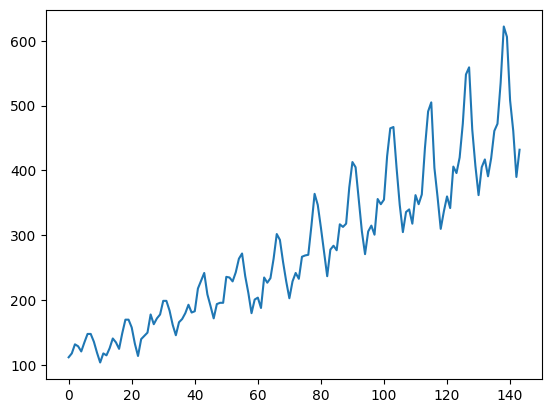

In [10]:
plt.plot(dataset['Passengers']);

In [11]:
#We transformed the 'Month' column into a datetime format and extracted the month component.
#We will use the passenger count and month information as an input to the model.
dataset['Month'] = pd.to_datetime(dataset['Month'])
dataset['Month'] = dataset['Month'].dt.month
dataset_values = dataset[['Passengers', 'Month']].values.astype('float32') #convert the integer values to floating point values, which are more suitable for modeling with a neural network.

### Split into train and test sets

In time series we must follow the order when splitting into train and test sets. This dataset was split into training and testing sets, with 67% of the data used for training.

In [12]:
train_size = int(len(dataset_values) * 0.67)
test_size = len(dataset_values) - train_size
train, test = dataset_values[0:train_size], dataset_values[train_size:len(dataset_values)]
print(len(train), len(test))

96 48


### Scaling data

We will use the passenger count and month information as an input to the model. <br>
It's generally a good practice to **Scale** your data before using it as input to a neural network, especially when dealing with features that have different scales or magnitudes. we are using 'MinMaxScaler' to scales both "Passengers" and "Month" to the [0, 1] range.

In [13]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)
test_scaled=scaler.transform(test)

In [14]:
# look_back: number of previous time steps to use as input variables to predict the next time period—in this case, defaulted to 1.
# output: X is the number of passengers at a given time (t), and Y is the number of passengers at the next time (t + 1).
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]  #get look_back sequences
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0]) #get the target after look_back sequences
    return np.array(dataX), np.array(dataY)

In [15]:
look_back = 5   #you are creating input sequences of length 5 (i.e., 5 time steps)
trainX, trainY = create_dataset(train_scaled, look_back)
testX, testY = create_dataset(test_scaled, look_back)

### Build a Stacked LSTM Model 
**The input to an LSTM network typically consists of a 3D tensor with the shape (batch_size, timesteps, input_features).**<br>
Samples: number of individual data points in your dataset <br>
Time steps : the number of data points in each sequence. It determines how far back in time the model looks when making predictions. <br>
Features : the number of features

In [16]:
print("trainX Shape: ",trainX.shape) #[samples, time steps, features]
print("trainY Shape: ",trainY.shape)

print("testX Shape: ",testX.shape) #[samples, time steps, features]
print("testY Shape: ",testY.shape)

trainX Shape:  (90, 5, 2)
trainY Shape:  (90,)
testX Shape:  (42, 5, 2)
testY Shape:  (42,)


**Stacked LSTM Model** <br>
In the first LSTM layer 'return_sequences=True' means it will return the full sequence of output, which is necessary if you want to stack LSTM layers. We designed a Stacked LSTM model with two LSTM layers and a Dense output layer. The choice of activation function was 'relu,' and we used the mean squared error (MSE) as the loss function. 

In [17]:
def create_stacked_lstm_model(units=50, activation='relu'):
    model = Sequential()
    model.add(LSTM(units, activation=activation, return_sequences=True, input_shape=(look_back, trainX.shape[2])))
    model.add(LSTM(units, activation=activation))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

stacked_model = create_stacked_lstm_model(units=50, activation='relu')

# fit model
stacked_model.fit(trainX, trainY, epochs=200, verbose=0)

### Test and Evaluate
**Test** the model with the test data. <br>
We had scaled our data so we need to **inverse** the scaling, making them interpretable in terms of the actual number of air passengers. <br>
**Mean Squared Error (MSE)** is a measure of the average squared difference between the predicted values and the actual values. A lower MSE indicates better model performance. <br>
**Root Mean Squared Error (RMSE)** is the square root of the MSE and provides a measure of the average prediction error in the same units as the target variable. A lower RMSE indicates better model performance.

In [18]:
stacked_test_predictions = stacked_model.predict(testX)

2/2 [==============================] - 0s 6ms/step


In [19]:
# Inverse transform and reshape predictions
def inverse_transform_and_reshape(predictions, scaler, shape):
    predictions_copies = np.repeat(predictions, shape[2], axis=-1)
    return scaler.inverse_transform(np.reshape(predictions_copies, (len(predictions), shape[2])))[:, 0]

stacked_pred = inverse_transform_and_reshape(stacked_test_predictions, scaler, trainX.shape)

# Original test label
original_copies_array = np.repeat(testY, trainX.shape[2], axis=-1)
original_testY = scaler.inverse_transform(np.reshape(original_copies_array, (len(testY), trainX.shape[2])))[:, 0]

In [20]:
print("Stacked Model:")
mse = mean_squared_error(original_testY, stacked_pred)
print("Mean Squared Error (MSE):", mse)
rmse = sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

Stacked Model:
Mean Squared Error (MSE): 778.6372
Root Mean Squared Error (RMSE): 27.904071513513042


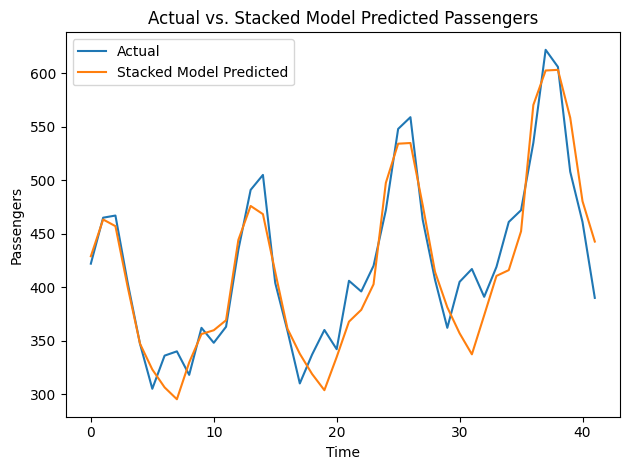

In [21]:
# Plot for Stacked Model
plt.plot(original_testY, label='Actual')
plt.plot(stacked_pred, label='Stacked Model Predicted')
plt.xlabel('Time')  # Use `xlabel` instead of `set_xlabel`
plt.ylabel('Passengers')
plt.legend()
plt.title('Actual vs. Stacked Model Predicted Passengers')  # Use `title` instead of `set_title`
plt.tight_layout() 
plt.show()

### Hyperparameter tuning with GridSearch 
Hyperparameter tuning was applied to optimize the performance of the Stacked LSTM model for time series forecasting. Hyperparameters are critical settings that control the behavior and architecture of the neural network. The goal was to identify the combination of hyperparameters that produced the best forecasting results. <br>

The **grid_search** function performs an exhaustive search over the parameter grid. This involved training and evaluating multiple instances of the Stacked LSTM model with different hyperparameter combinations.

The **evaluate_model** function makes predictions with the model on the test data, inverse-transform the predictions to their original scale, and calculate performance metrics.

In [ ]:
%%capture
!pip install tensorflow==2.12.0

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from keras.wrappers.scikit_learn import KerasRegressor

In [23]:
def grid_search(model_type, param_grid):
    regressor = KerasRegressor(build_fn= model_type, verbose=0)
    grid_search = GridSearchCV(estimator=regressor, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
    grid_search.fit(trainX, trainY)
    return grid_search.best_estimator_.model, grid_search.best_params_

def evaluate_model(model, testX, testY, scaler, trainX_shape):
    predictions = model.predict(testX)
    predictions = inverse_transform_and_reshape(predictions, scaler, trainX_shape) #inverse the scaling
    
    original_copies_array = np.repeat(testY, trainX.shape[2], axis=-1)
    original_testY = scaler.inverse_transform(np.reshape(original_copies_array, (len(testY), trainX.shape[2])))[:, 0]#inverse the scaling of testY

    mse = mean_squared_error(original_testY, predictions)
    rmse = np.sqrt(mse)
    return predictions, original_testY, mse, rmse

In [24]:
# Define parameter grid
param_grid = {'units': [4, 20, 50],
              'batch_size' : [10, 20, 32, 40, 100],
              'epochs' : [10, 50, 100, 200]}

# Train and evaluate stacked LSTM
stacked_best_model, stacked_best_params = grid_search(create_stacked_lstm_model, param_grid)
stacked_pred, original_testY, stacked_mse, stacked_rmse = evaluate_model(stacked_best_model, testX, testY, scaler, trainX.shape)

/tmp/ipykernel_42/1039615028.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  regressor = KerasRegressor(build_fn= model_type, verbose=0)


2/2 [==============================] - 0s 6ms/step


In [25]:
print("Stacked Model:")
print("Best Hyperparameters:", stacked_best_params)
print("Mean Squared Error (MSE):", stacked_mse)
print("Root Mean Squared Error (RMSE):", stacked_rmse)

Stacked Model:
Best Hyperparameters: {'batch_size': 10, 'epochs': 200, 'units': 50}
Mean Squared Error (MSE): 684.8771
Root Mean Squared Error (RMSE): 26.170156


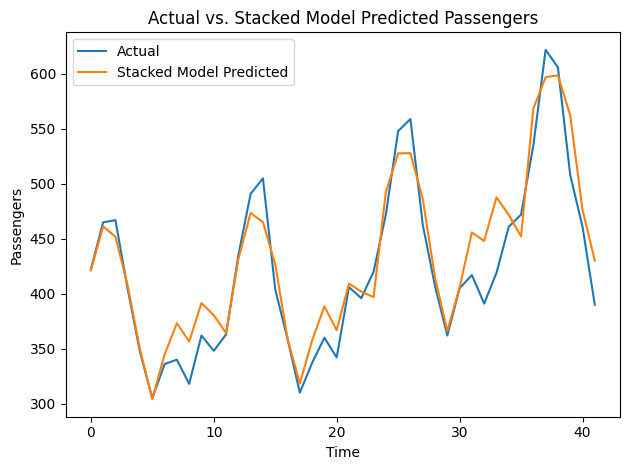

In [26]:
# Plot for Stacked Model
plt.plot(original_testY, label='Actual')
plt.plot(stacked_pred, label='Stacked Model Predicted')
plt.xlabel('Time')  # Use `xlabel` instead of `set_xlabel`
plt.ylabel('Passengers')
plt.legend()
plt.title('Actual vs. Stacked Model Predicted Passengers')  # Use `title` instead of `set_title`
plt.tight_layout() 
plt.show()

### Conclusion

In [41]:
display(Markdown(f" **MSE Improvement**: After hyperparameter tuning, the MSE decreased from {mse} to {stacked_mse}. This indicates that the model's predictions became closer to the actual values on average, reflecting improved accuracy."))
display(Markdown(f" **RMSE Improvement**: The RMSE also decreased from {rmse} to {stacked_rmse}. A lower RMSE signifies that the model's predictions had smaller errors and were more precise."))
display(Markdown(f" Best Hyperparameters: The best hyperparameters obtained through the tuning process were a batch size of 10, 200 training epochs, and 50 LSTM units. These hyperparameters led to the improved performance of the model."))
display(Markdown(f"Note: **Results can vary** for different users and different runs of the analysis due to several factors, including random initialization of model weights, and differences in computing environments. Therefore, when applying these techniques to your own projects, it's advisable to perform multiple runs and cross-validation to ensure robustness and account for variability."))

 **MSE Improvement**: After hyperparameter tuning, the MSE decreased from 778.63720703125 to 684.8770751953125. This indicates that the model's predictions became closer to the actual values on average, reflecting improved accuracy.

 **RMSE Improvement**: The RMSE also decreased from 27.904071513513042 to 26.170156478881836. A lower RMSE signifies that the model's predictions had smaller errors and were more precise.

 Best Hyperparameters: The best hyperparameters obtained through the tuning process were a batch size of 10, 200 training epochs, and 50 LSTM units. These hyperparameters led to the improved performance of the model.

Note: **Results can vary** for different users and different runs of the analysis due to several factors, including random initialization of model weights, and differences in computing environments. Therefore, when applying these techniques to your own projects, it's advisable to perform multiple runs and cross-validation to ensure robustness and account for variability.